In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy import linalg

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

def skridge(x,y,z,l,deg):
    model = Ridge(l)
    sk_X = get_X_poly2D(x,y,deg)
    par = model.fit(sk_X,z)
    pred = model.predict(sk_X)
    
    return pred,model.coef_

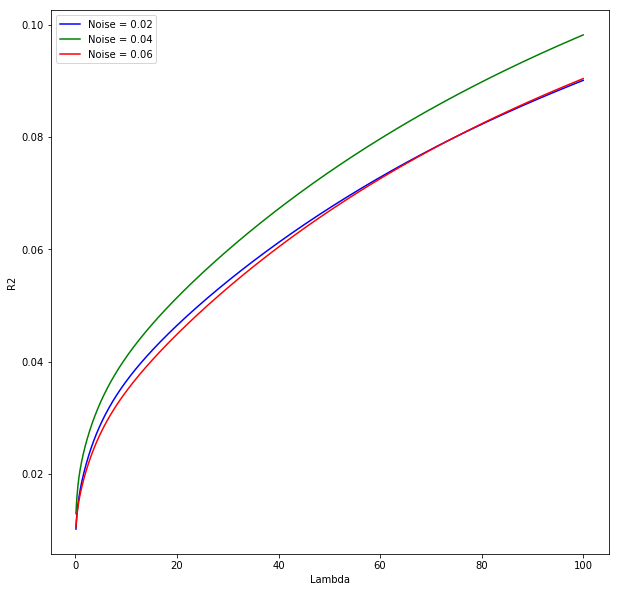

In [4]:
from tools import *
from plotting import *
from IPython.display import clear_output

#x,y,z,noise = generate_data()

deg = 5

lmbd_runs = 1000
noise_runs = 3
MSE = np.zeros((lmbd_runs,noise_runs))
R2 = np.zeros((lmbd_runs,noise_runs))
R2_cross = np.zeros((lmbd_runs,noise_runs))
#MSE_sk = np.zeros((lmbd_runs,noise_runs))
#R2_sk = np.zeros((lmbd_runs,noise_runs))
lmbd_step = 0.1
k = 11
for j in range(noise_runs):
    x,y,z,noise = generate_data(N = 220, noise = (j+1)*0.02)
    for a in range(1,lmbd_runs+1):
        lambd = a * lmbd_step
        #regr = fit_poly2D(x, y, z, deg = deg, lmbd = lambd)
#         #plot_data_3D(x,y,z,regr.yhat,regr.beta)
#         #plt.show()

        #MSE[a-1][j] = squared_error(z, regr.yhat)
        #R2[a-1][j] = r2score(z, regr.yhat) #BAD: scoring training data
        
        r2_train,mse_train, r2_test, mse_test = k_fold_val(x,y,z,k=k,lmbd = lambd,
                                                          method = 'ridge')
        #R2_cross[a-1][j] = r2_test
        MSE[a-1][j] = mse_test
        
        #R2[a-1][j] = r2_train

        #sk_z,sk_beta = skridge(x,y,z,lambd,deg)
        #MSE_sk[a-1][j] = squared_error(z, sk_z)
        #R2_sk[a-1][j] = r2_score(z, sk_z)
    
    
x_ = lmbd_step*np.arange(1,lmbd_runs+1)


clr = ['b', 'g', 'r', 'm', 'y']

plt.figure(figsize=(10,10))
# plt.subplot(121)
for q in range(noise_runs):
    plt.plot(x_,MSE[:,q],clr[q]+'-')
plt.legend(['Noise = {}'.format((i+1)*0.02) for i in range(noise_runs)])
plt.xlabel('Lambda')
plt.ylabel('R2')
# for q in range(noise_runs):
#     plt.plot(x_,R2[:,q],clr[q]+'--')

# plt.subplot(122)
# for q in range(noise_runs):
#     plt.plot(x_,R2_cross[:,q],'-')
#     #plt.plot(x_,MSE_sk[:,q],'--')
# plt.legend(['noise = {}'.format((i+1)*0.02) for i in range(noise_runs)])
# plt.xlabel('Lambda')
# plt.ylabel('R2 k-fold average')

# plt.subplot(122)
# plt.plot(x_, np.abs(R2 - R2_sk))
# #plt.plot(x_,R2_sk)

# #print('%-20s%-20s%-20s' % ('model','sklearn','difference'))
# #for i in range(runs):
# #    print('%-20s%-20s%-20s' % (R2[i],R2_sk[i], np.abs(R2[i] - R2_sk[i])))

# plt.plot(R2,R2_sk, 'ro')
# #plt.plot([0,R2[-1]], [0,R2[-1]])
# plt.axis('equal')
# # plt.axis([np.min(R2), np.max(R2), np.min(R2_sk),np.max(R2_sk)])

# plt.xlabel('model')
# plt.ylabel('sklearn')
#plt.show()
    

In [5]:
def k_fold(x, y, z, k = 2, lmbd=0, method = 'ridge',
        return_average = True):
    N = x.size
    if method.lower() not in ['ols','ridge','lasso']:
        raise ValueError('Invalid method flag, {}'.format(method))
    if method.lower() == 'ols' and lmbd != 0:
        raise ValueError('lmbd != 0 does not make sense for OLS.')
    if method.lower() == 'lasso':
        from sklearn.linear_model import Lasso


    N = x.size
    indexes = np.linspace(0,N,k+1, dtype = int)
    sizes = np.diff(indexes)
    
    r2_test = []
    mse_test = []
    r2_train = []
    mse_train = []
    for size in sizes:
        x_test = x[:size]
        y_test = y[:size]
        z_test = z[:size]
        x_train = x[size:]
        y_train = y[size:]
        z_train = z[size:]
    
        # print(x_train.shape, x_test.shape)
        design_train = get_X_poly2D(x_train, y_train, deg =5)
        design_test = get_X_poly2D(x_test, y_test, deg =5)

        if method.lower() == 'ols' or method.lower() == 'ridge':
            regr = Regression(design_train,z_train, lmbd = lmbd)
            var = np.diag(((design_test.dot(regr.betaVar)) @ design_test.T))
        else:
            regr = Lasso( alpha = lmbd ,fit_intercept = False)
            regr.fit(design_train, z_train)

        z_pred_test = regr.predict(design_test)
        z_pred_train = regr.predict(design_train)

        r2_test.append(r2score(z_test, z_pred_test))
        mse_test.append(squared_error(z_test, z_pred_test))
        r2_train.append(r2score(z_train, z_pred_train))
        mse_train.append(squared_error(z_train,z_pred_train))

        # print("{:6.3f}  {:6.3f}".format(r2[i], se[i]), )

        x = np.roll(x, - size)
        y = np.roll(y, - size)
        z = np.roll(z, - size)
    
    if return_average:
        #return ([np.average(v) for v in [r2_train,mse_train,
                                       #r2_test, mse_test]], var)
        return var
    else:
        return r2_train,mse_train, r2_test, mse_test

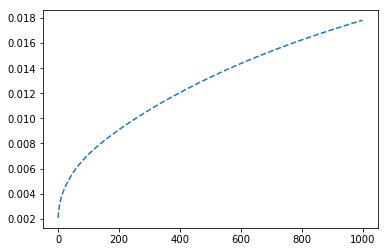

In [6]:
x,y,z,noise = generate_data(N = 220, noise = 0.02)
runs = 1000
Var = np.zeros((runs,))
for i in range(runs):
    lambd = 0.1 + i*0.1
    var = k_fold(x,y,z,k=k,lmbd = lambd,
                                                          method = 'ridge')
    Var[i] = np.average(var)
    
x_ = np.arange(runs)

plt.plot(x_,Var,'--')
plt.show()

In [7]:
from readdata import plotdata

file = './data/n59_e010_1arc_v3.tif'
#file2 = './data/nepal.tif'


plotdata(file)


NameError: name 'getdata' is not defined

In [ ]:
%matplotlib

In [ ]:
from imageio import imread

file = './data/n59_e010_1arc_v3.tif'
#plt.rcParams.update({'font.size': 13})
#fig = plt.figure(figsize = [10,6])
#ax = fig.add_subplot(111,projection = '3d')

z = imread(file)
n,m = z.shape
x = np.arange(0,m)
y = np.arange(0,n)
x, y = np.meshgrid(x,y)

m = plt.imshow(z)
plt.colorbar(m)


#X = get_X_poly2D(x, y, deg = 3)
regr = fit_poly2D(x.ravel(),y.ravel(),z.ravel(), deg = 3, lmbd = 0)
print(regr.beta)


# ax.scatter(x,y,z)
# ax.set_xlabel('$x$')
# ax.set_ylabel('$y$')
# ax.set_zlabel('$f(x,y)$')

In [ ]:
a= regr.r2score()
print(a)

In [ ]:
plt.show()

In [246]:
import tools
import plotting
import random

def bootstrap(x,y,z, rep=50, smplsize = 50):
    MSE = np.zeros((rep,))
    
    indx = np.arange(x.size)
    for r in range(rep):
        rnd1 = np.random.choice(indx, size = smplsize)
        uniq =  np.unique(rnd1)
        
        train_x = x[rnd1]
        train_y = y[rnd1]
        train_z = z[rnd1]

        mask = np.zeros_like(x, dtype=bool)
        mask[uniq] = True
        test_x = x[~mask]
        test_y = y[~mask]
        test_z = z[~mask]

        X_train = tools.get_X_poly2D(train_x,train_y, deg=5)
        X_test = tools.get_X_poly2D(test_x,test_y, deg=5)
        
        regr = tools.Regression(X_train, train_z)
        z_pred = regr.predict(X_test)
        MSE[r] = tools.squared_error(z_pred, test_z)
        
    return MSE


52.0593935949


In [254]:

def bootstrap_predict_point(x,y,z,x0 = 0.5, y0 = 0.5, rep=50):
    points = np.zeros((rep,))
    
    indx = np.arange(x.size)
    for r in range(rep):
        rnd1 = np.random.choice(indx, size = x.size)
        uniq =  np.unique(rnd1)
        
        train_x = x[rnd1]
        train_y = y[rnd1]
        train_z = z[rnd1]

        mask = np.zeros_like(x, dtype=bool)
        mask[uniq] = True


        X_train = tools.get_X_poly2D(train_x,train_y, deg=5)
        X_test = tools.get_X_poly2D(np.array([x0]),np.array([y0]), deg=5)
        
        regr = tools.Regression(X_train, train_z)
        z_pred = regr.predict(X_test)
        points[r] = z_pred
        
    return points

x0, y0 = [0.5,0.5]
points = bootstrap_predict_point(x,y,z, x0, y0, rep = 200)

(0.01, 0.02276824997593559, 0.0086301531175774545, 0.018544909385970563)

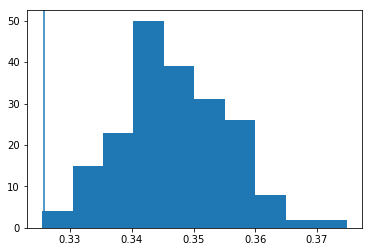

In [263]:
from franke import FrankeFunction
plt.hist(points)
z0 = FrankeFunction(x0,y0)
plt.axvline(z0)
var = np.var(points) #squared
err = np.mean((points-z0)**2) #squared
bias = err-noise**2-var #squared
noise,np.sqrt(err), np.sqrt(var), np.sqrt(bias)

In [ ]:
x,y,z,noise = tools.generate_data(N = 220, noise = 0.01)
mse = bootstrap(x,y,z, smplsize=22)
print(np.average(mse))



In [13]:
a = np.array([16,4,8,0,4,2])
print(a)
#a = np.sort(a)
a= np.delete(a,2)
print(a)
print(np.unique(a))


[16  4  8  0  4  2]
[16  4  0  4  2]
[ 0  2  4 16]


In [136]:

a = np.array([16,4,8,0,4,4,4,4,2])
indx = np.arange(a.size)
rnd1 = np.array([0,1,1,5])# np.random.choice(indx, size = 4)
u =  np.unique(rnd1)
print(u)
r = a[rnd1]
print('a',a)
print('r',r)

mask = np.zeros(a.shape,dtype=bool)
mask[u] = True
print('ikke med: ',a[~mask])
print('med', a[mask])

[0 1 5]
a [16  4  8  0  4  4  4  4  2]
r [16  4  4  4]
ikke med:  [8 0 4 4 4 2]
med [16  4  4]
